<a href="https://colab.research.google.com/github/abaskon/Thesis/blob/main/GPR_DBI_VAR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Import Libraries

In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 10.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



#####Read data and standardise them

In [3]:
dbi1 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI1985-2004.csv")
dbi2 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI2004-today.csv")

dbi1['Price'] = dbi1['Price'].str.replace(',', '').astype(float)
dbi2['Price'] = dbi2['Price'].str.replace(',', '').astype(float)

In [4]:
dbi1['Date'] = pd.to_datetime(dbi1['Date'], format='%m/%d/%Y')
dbi2['Date'] = pd.to_datetime(dbi2['Date'], format='%m/%d/%Y')

In [5]:
dbi1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2004-11-22,5442.0,"5,442.00","5,442.00","5,442.00",NaN,0.91%
1,2004-11-19,5393.0,"5,393.00","5,393.00","5,393.00",NaN,1.09%
2,2004-11-18,5335.0,"5,335.00","5,335.00","5,335.00",NaN,1.35%
3,2004-11-17,5264.0,"5,264.00","5,264.00","5,264.00",NaN,1.41%
4,2004-11-16,5191.0,"5,191.00","5,191.00","5,191.00",NaN,0.76%


In [6]:
# concatenate the two tables based on the 'date' column
DBI = pd.concat([dbi1, dbi2]).drop_duplicates(subset='Date')

DBI = DBI.sort_values(by='Date', ascending=True)
DBI = DBI.reset_index(drop=True)

In [7]:
DBI

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%
3,1985-01-10,979.5,979.50,979.50,979.50,NaN,-1.51%
4,1985-01-11,980.5,980.50,980.50,980.50,NaN,0.10%
...,...,...,...,...,...,...,...
9595,2023-04-28,1576.0,"1,576.00","1,576.00","1,576.00",NaN,-0.32%
9596,2023-05-02,1552.0,"1,552.00","1,552.00","1,552.00",NaN,-1.52%
9597,2023-05-03,1558.0,"1,558.00","1,558.00","1,558.00",NaN,0.39%
9598,2023-05-04,1545.0,"1,545.00","1,545.00","1,545.00",NaN,-0.83%


In [8]:
GPR = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_daily_recent.csv")
GPRE = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_export.csv")
GPR['GPRD'] = GPR['GPRD'].str.replace(',', '').astype(float)


In [9]:
GPR

,DAY,N10D,GPRD,GPRD_ACT,GPRD_THREAT,date,GPRD_MA30,GPRD_MA7,event,var_name,var_label
0,19850101,216,230.04,275.20,153.03,01-01-1985,230.04,230.04,NaN,DAY,DAY
1,19850102,315,115.68,146.77,87.44,02-01-1985,172.86,172.86,NaN,N10D,"Number of articles (10 recent newspapers, 1985-)"
2,19850103,374,97.43,158.94,29.46,03-01-1985,147.71,147.71,NaN,GPRD,Daily GPR (Index: 1985:2019=100)
3,19850104,421,157.37,156.88,157.03,04-01-1985,150.13,150.13,NaN,GPRD_ACT,Daily GPR Acts (Index: 1985:2019=100)
4,19850105,285,81.36,92.70,77.32,05-01-1985,136.37,136.37,NaN,GPRD_THREAT,Daily GPR Threats (Index: 1985:2019=100)
...,...,...,...,...,...,...,...,...,...,...,...
13988,20230420,470,98.67,126.47,70.33,20-04-2023,93.04,98.11,NaN,NaN,NaN
13989,20230421,453,117.00,102.06,121.61,21-04-2023,92.90,98.72,NaN,NaN,NaN
13990,20230422,522,63.46,101.22,31.66,22-04-2023,91.56,95.33,NaN,NaN,NaN
13991,20230423,355,55.99,93.02,31.04,23-04-2023,90.75,97.36,NaN,NaN,NaN


In [10]:
GPR['date'] = pd.to_datetime(GPR['date'], format='%d-%m-%Y')
GPR = GPR.rename(columns={'date': 'Date'})

In [11]:
GPR = GPR[['Date', 'GPRD', 'event']]

In [12]:
GPR.head(4)

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN
3,1985-01-04,157.37,NaN


In [13]:
GPRE['month'] = pd.to_datetime(GPRE['month'], format='%d-%m-%Y')
GPRE = GPRE.rename(columns={'month': 'Date'})

In [14]:
GPRE.head(6)

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
0,1900-01-01,NaN,NaN,NaN,87.93,64.72,110.45,NaN,NaN,3.17,...,0.08,0.00,0.04,0.00,0.0,2.72,0.05,1.15,month,Date (year/month)
1,1900-02-01,NaN,NaN,NaN,86.57,71.94,96.25,NaN,NaN,3.12,...,0.08,0.00,0.13,0.00,0.0,2.73,0.03,1.14,GPR,Recent GPR (Index: 1985:2019=100)
2,1900-03-01,NaN,NaN,NaN,72.14,57.48,84.50,NaN,NaN,2.60,...,0.12,0.00,0.18,0.00,0.0,2.15,0.03,0.86,GPRT,Recent GPR Threats (Index: 1985:2019=100)
3,1900-04-01,NaN,NaN,NaN,54.42,37.33,65.86,NaN,NaN,1.96,...,0.04,0.00,0.07,0.00,0.0,1.78,0.00,0.64,GPRA,Recent GPR Acts (Index: 1985:2019=100)
4,1900-05-01,NaN,NaN,NaN,64.41,48.20,74.37,NaN,NaN,2.32,...,0.16,0.00,0.08,0.00,0.0,1.97,0.01,0.79,GPRH,Historical GPR (Index: 1900:2019=100)
5,1900-06-01,NaN,NaN,NaN,83.61,70.01,93.98,NaN,NaN,3.02,...,0.08,0.01,0.11,0.03,0.0,2.73,0.03,0.67,GPRHT,Historical GPR Threats (Index: 1900:2019=100)


In [15]:
GPRE[GPRE["Date"] == "1985-02-01"]

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
1021,1985-02-01,117.1,126.44,96.6,99.55,127.21,75.1,3.51,10819.0,3.59,...,0.2,0.04,0.03,0.0,0.01,3.34,0.07,0.11,NaN,NaN


In [16]:
GPR[GPR["Date"] == "1985-02-01"]

,Date,GPRD,event
31,1985-02-01,106.61,NaN


In [17]:
GPRE = GPRE[['Date', 'GPR','GPRC_ARG', 'GPRC_AUS', 'GPRC_BEL', 'GPRC_BRA', 'GPRC_CAN', 'GPRC_CHE', 'GPRC_CHL', 'GPRC_CHN', 'GPRC_COL', 'GPRC_DEU', 'GPRC_DNK', 'GPRC_EGY', 'GPRC_ESP', 'GPRC_FIN', 'GPRC_FRA', 'GPRC_GBR', 'GPRC_HKG', 'GPRC_HUN', 'GPRC_IDN', 'GPRC_IND', 'GPRC_ISR', 'GPRC_ITA', 'GPRC_JPN', 'GPRC_KOR', 'GPRC_MEX', 'GPRC_MYS', 'GPRC_NLD', 'GPRC_NOR', 'GPRC_PER', 'GPRC_PHL', 'GPRC_POL', 'GPRC_PRT', 'GPRC_RUS', 'GPRC_SAU', 'GPRC_SWE', 'GPRC_THA', 'GPRC_TUN', 'GPRC_TUR', 'GPRC_TWN', 'GPRC_UKR', 'GPRC_USA', 'GPRC_VEN', 'GPRC_ZAF']]

In [18]:
GPRE = GPRE[GPRE['Date'] >= '1985-01-01']

In [19]:
GPRE

,Date,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
1020,1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1021,1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1022,1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1023,1985-04-01,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1024,1985-05-01,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,2022-11-01,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
1475,2022-12-01,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
1476,2023-01-01,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04
1477,2023-02-01,127.34,0.01,0.16,0.34,0.06,0.42,0.05,0.04,1.58,...,0.15,0.15,0.02,0.01,0.51,0.37,2.12,3.15,0.02,0.10


#####Visualisations

In [20]:
def plotgraph(df, x, y):
    df[y] = pd.to_numeric(df[y])
    df.plot(x=x, y=y, figsize=(20, 4))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('USD per Metric Tonne')
    plt.show()


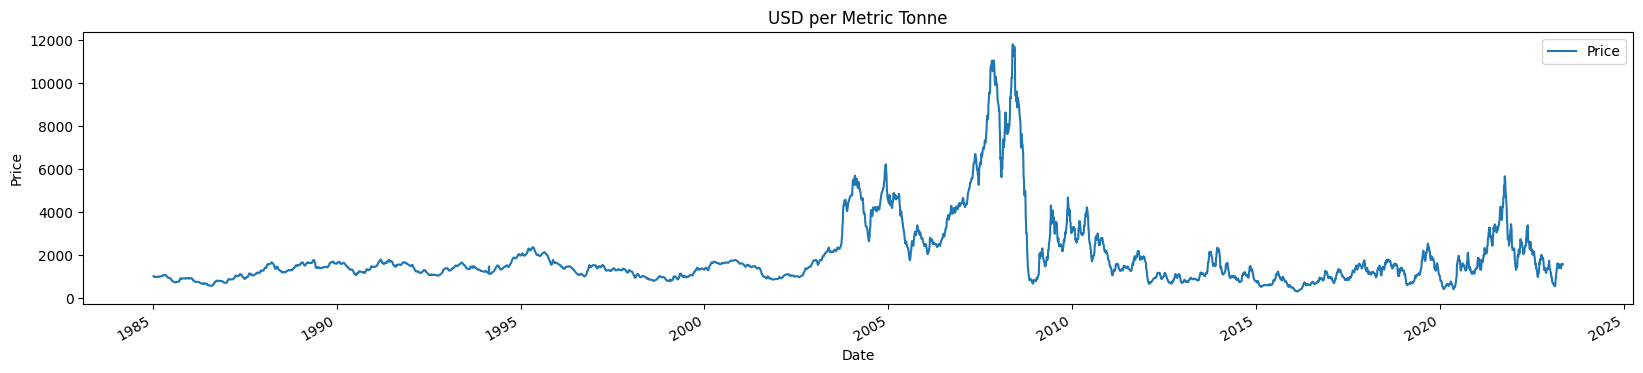

In [21]:
plotgraph(DBI,'Date','Price')

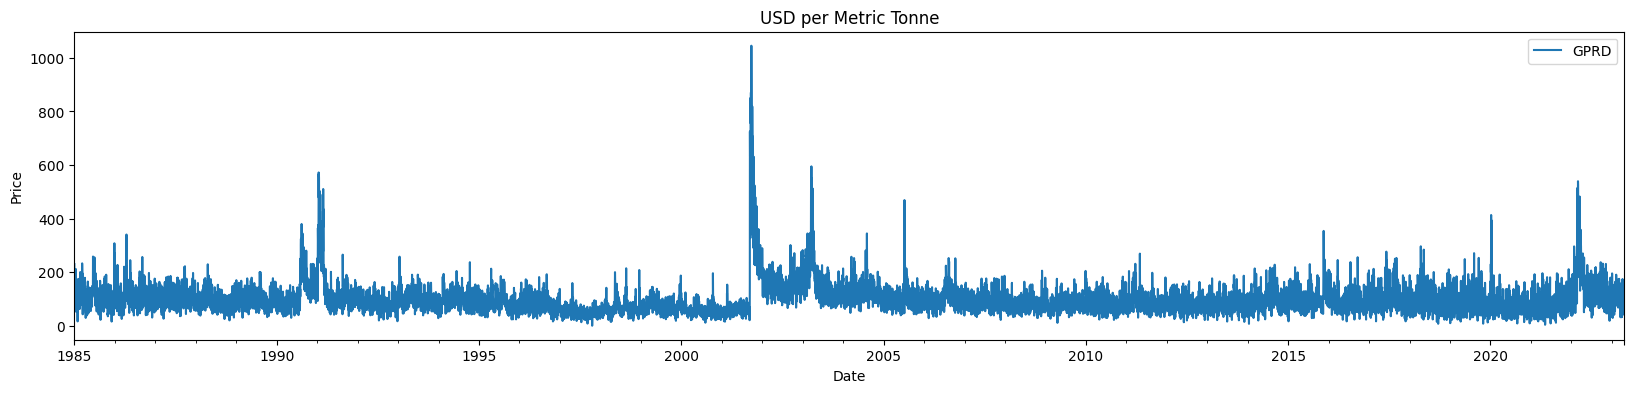

In [22]:
plotgraph(GPR,'Date','GPRD')

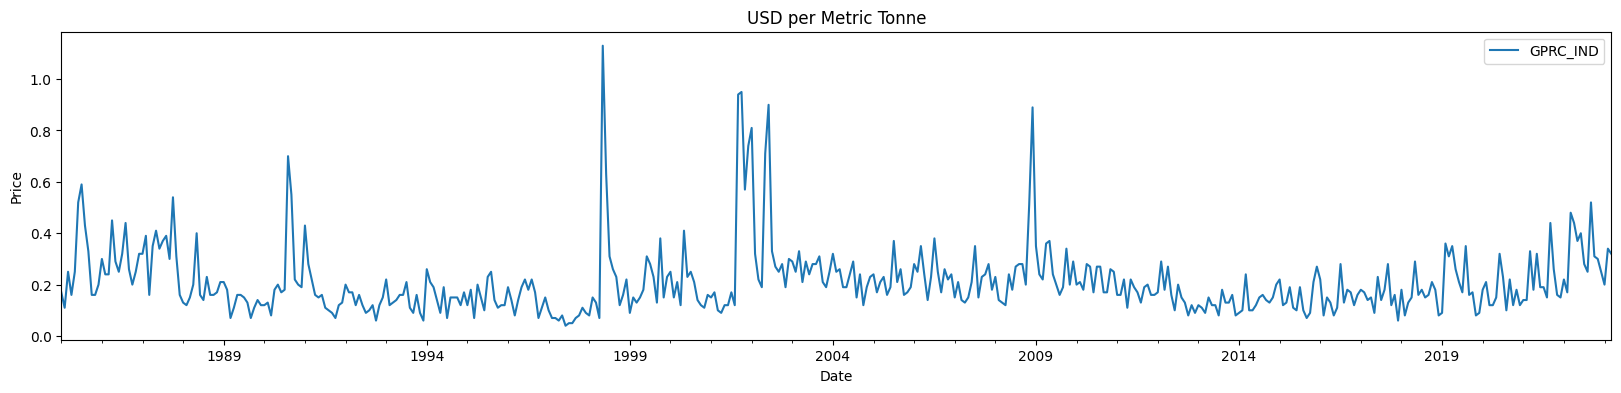

In [23]:
plotgraph(GPRE,'Date','GPRC_IND')

In [24]:
# Plotly line plot
fig = go.Figure(data=[go.Scatter(x=DBI['Date'], y=DBI['Price'])])
fig.show()


#####Others

In [25]:
DBI.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%


In [26]:
DBI = DBI[['Date','Price']]


In [27]:
DBI.set_index('Date', inplace=True)

In [28]:

# Resample the data to monthly frequency and calculate the average
DBIM = DBI.resample('M').mean()

# Generate the desired dates for each month
start_date = DBIM.index[0].replace(day=1)
end_date = DBIM.index[-1]
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m-%d')

# Update the index with the monthly dates
DBIM.index = monthly_dates


In [29]:
DBIM.index = pd.to_datetime(DBIM.index)

In [30]:
DBIM.head(3)

,Price
1985-01-01,979.210526
1985-02-01,974.075000
1985-03-01,994.414286


In [31]:
GPR.head(3)#No USE

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN


In [32]:
GPRE.set_index('Date', inplace=True)
GPRE.head(3)

,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,0.03,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,0.06,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,0.06,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15


#####Merge Files

In [33]:
DATA = pd.merge(DBIM, GPRE, left_index=True, right_index=True)
DATA = DATA.rename_axis('Date')


In [34]:
DATA

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,974.075000,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1985-03-01,994.414286,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1985-04-01,1045.275000,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1985-05-01,1004.309524,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,1298.954545,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
2022-12-01,1453.411765,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
2023-01-01,908.809524,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04


#####Preliminary analysis

In [35]:
#Data from Yahoo Finance
EconomyData = pd.read_csv('https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DataEconomy.csv')
EconomyData.head()

,Date,USDINRClose,CrudeOil,Gold
0,12-06-2017,64.394997,44.740002,1254.000000
1,19-06-2017,64.498001,43.009998,1256.199951
2,26-06-2017,64.606796,46.040001,1240.699951
3,03-07-2017,64.611702,44.230000,1208.599976
4,10-07-2017,64.267303,46.540001,1226.599976


In [36]:
print(DATA.describe())

              Price         GPR    GPRC_ARG    GPRC_AUS    GPRC_BEL  \
count    459.000000  459.000000  459.000000  459.000000  459.000000   
mean    1880.561310  100.647211    0.031046    0.086623    0.139956   
std     1605.455852   47.915949    0.028296    0.070291    0.125622   
min      306.904762   39.050000    0.000000    0.000000    0.010000   
25%     1031.597403   79.395000    0.010000    0.040000    0.070000   
50%     1401.800000   90.610000    0.020000    0.070000    0.110000   
75%     1933.772727  109.080000    0.040000    0.110000    0.170000   
max    10843.650000  512.530000    0.260000    0.530000    1.030000   

         GPRC_BRA    GPRC_CAN    GPRC_CHE    GPRC_CHL    GPRC_CHN  ...  \
count  459.000000  459.000000  459.000000  459.000000  459.000000  ...   
mean     0.047320    0.226405    0.059826    0.018802    0.422919  ...   
std      0.032875    0.160720    0.055552    0.022048    0.291199  ...   
min      0.000000    0.060000    0.000000    0.000000    0.07000

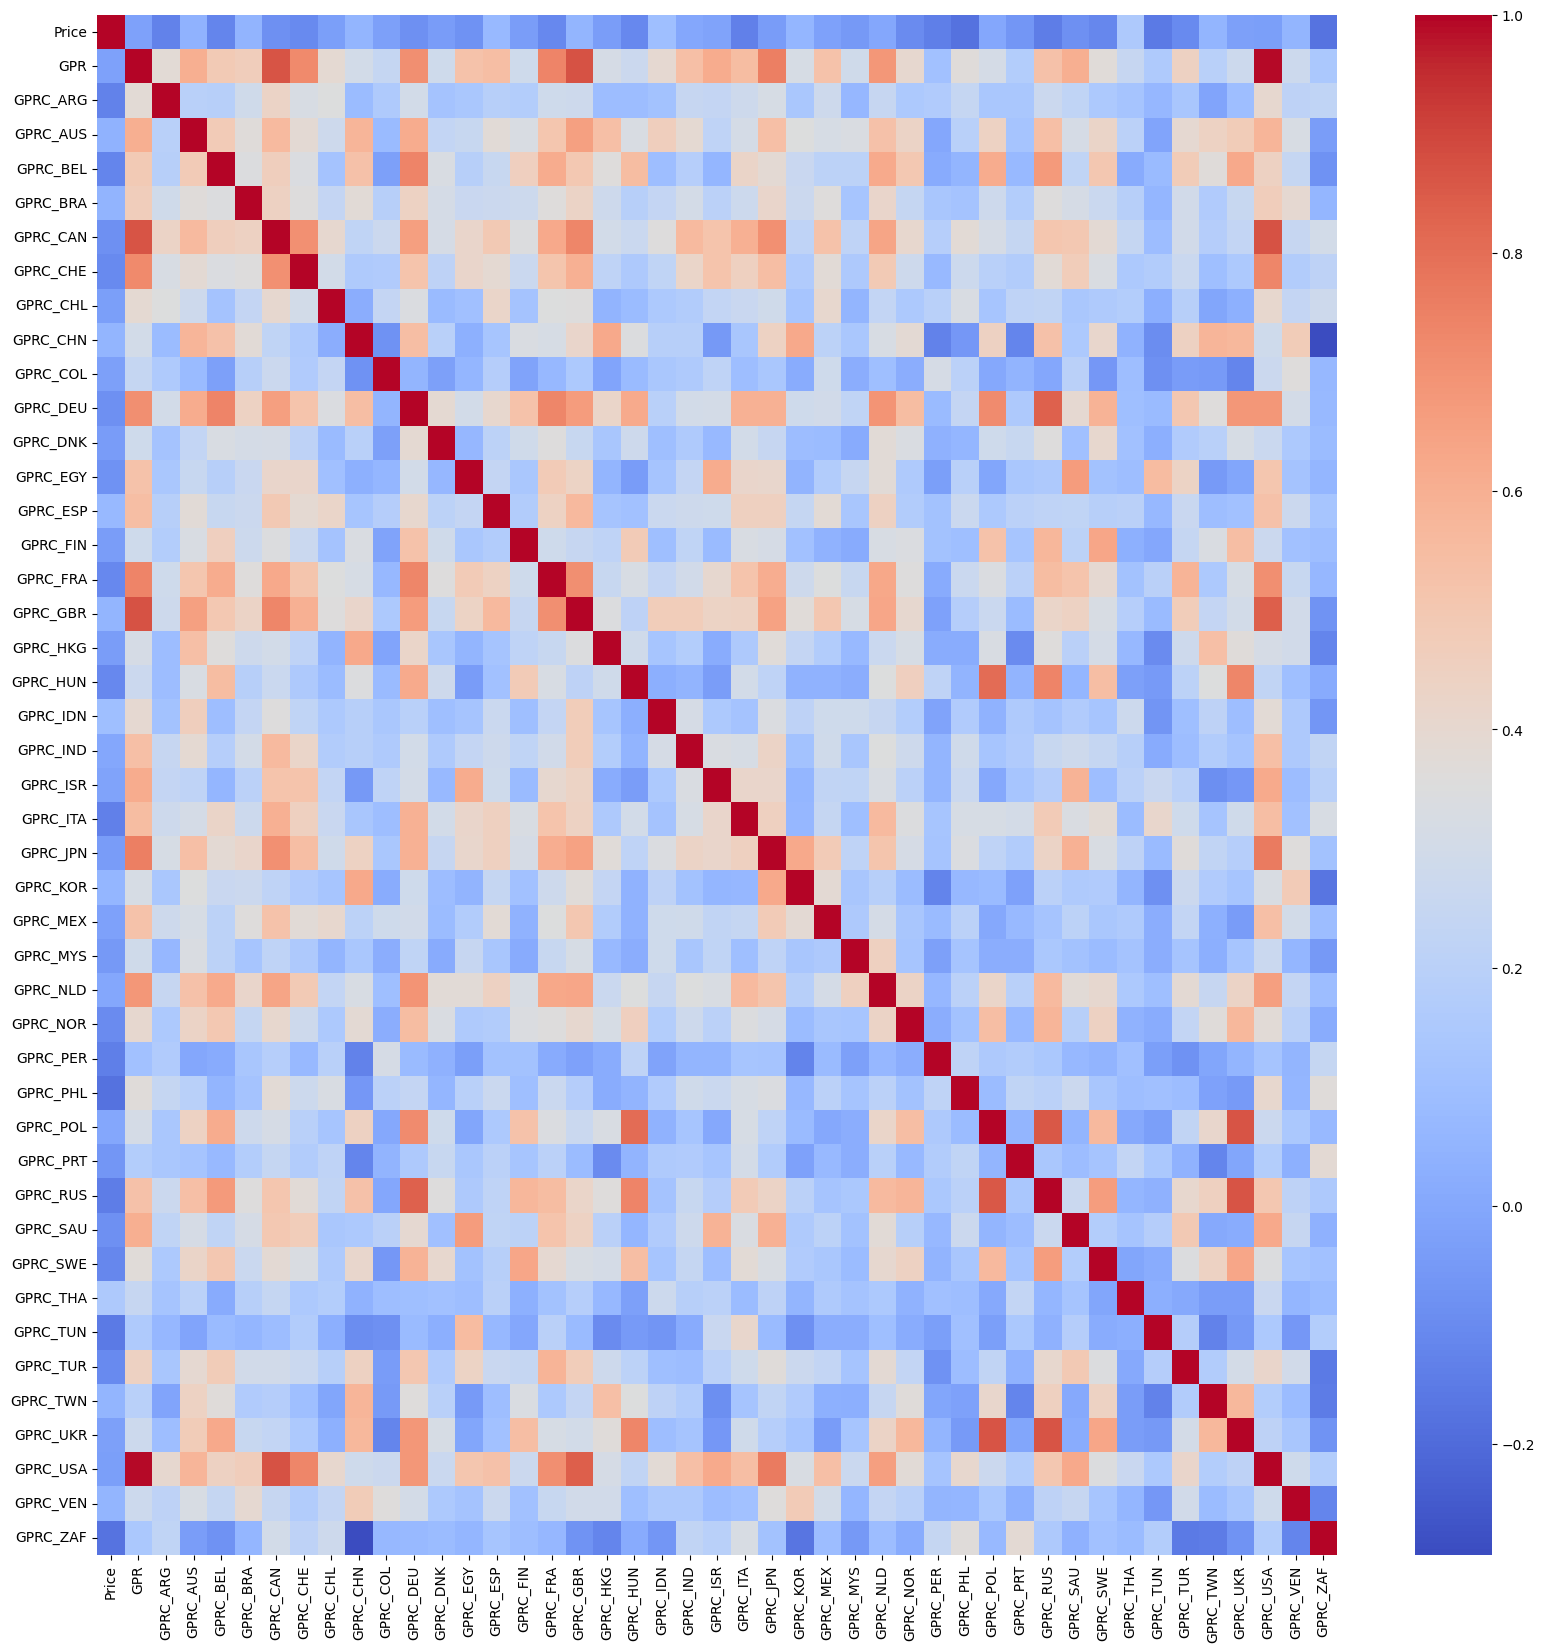

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(DATA.corr(),cmap='coolwarm');

<ipython-input-38-f54c41804d8a>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Price', ylabel='Density'>

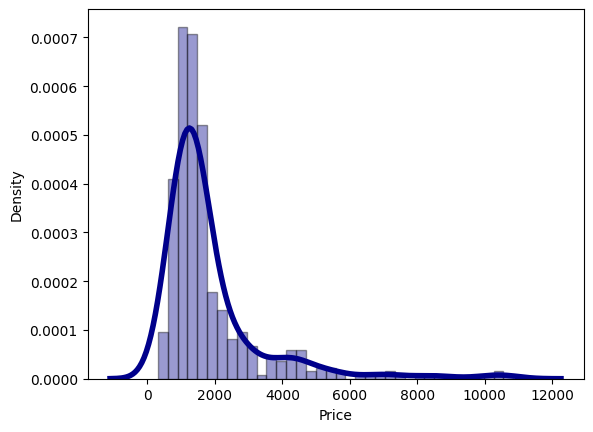

In [38]:
sns.distplot(DATA['Price'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<ipython-input-39-f9d9a019782f>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='GPR', ylabel='Density'>

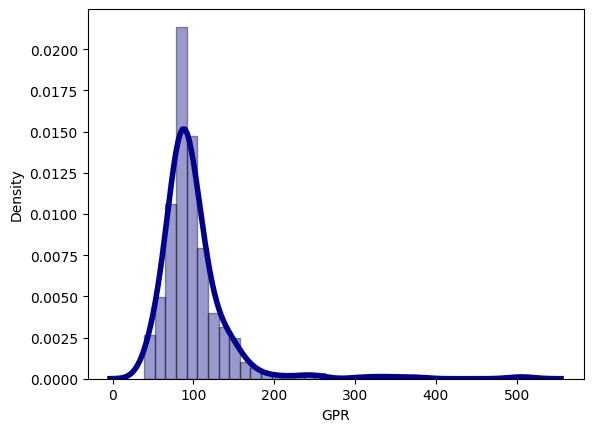

In [39]:
sns.distplot(DATA['GPR'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [40]:
DATA.head(2)

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,974.075000,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08


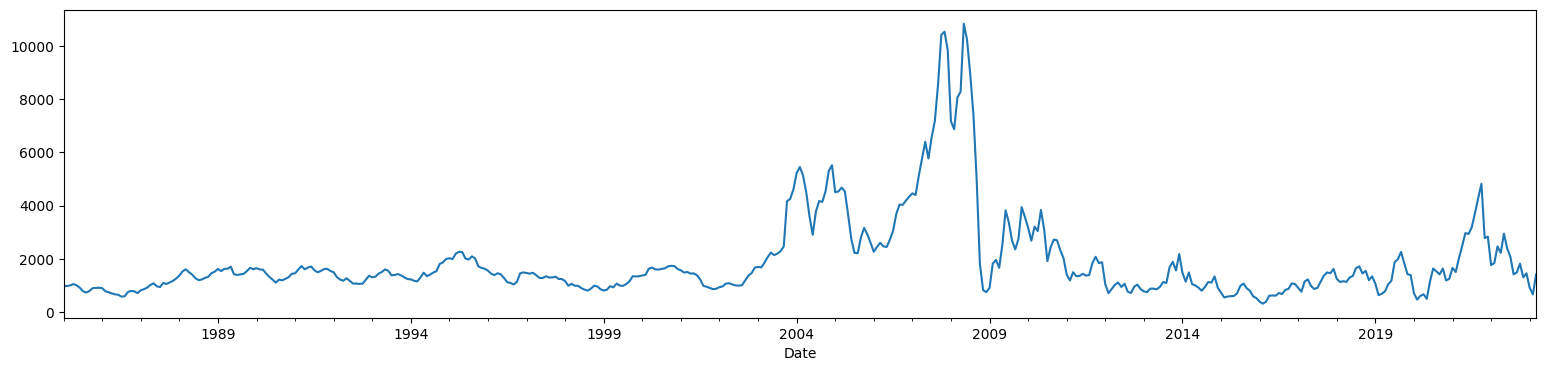

In [41]:
DATA['Price'].plot(figsize=(19, 4))
plt.show()

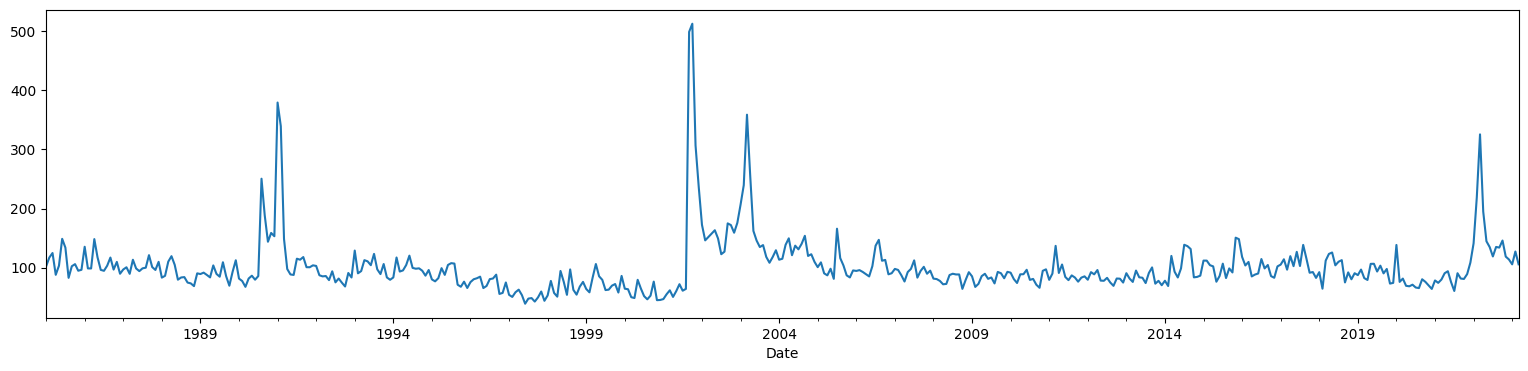

In [42]:
DATA['GPR'].plot(figsize=(19, 4))
plt.show()

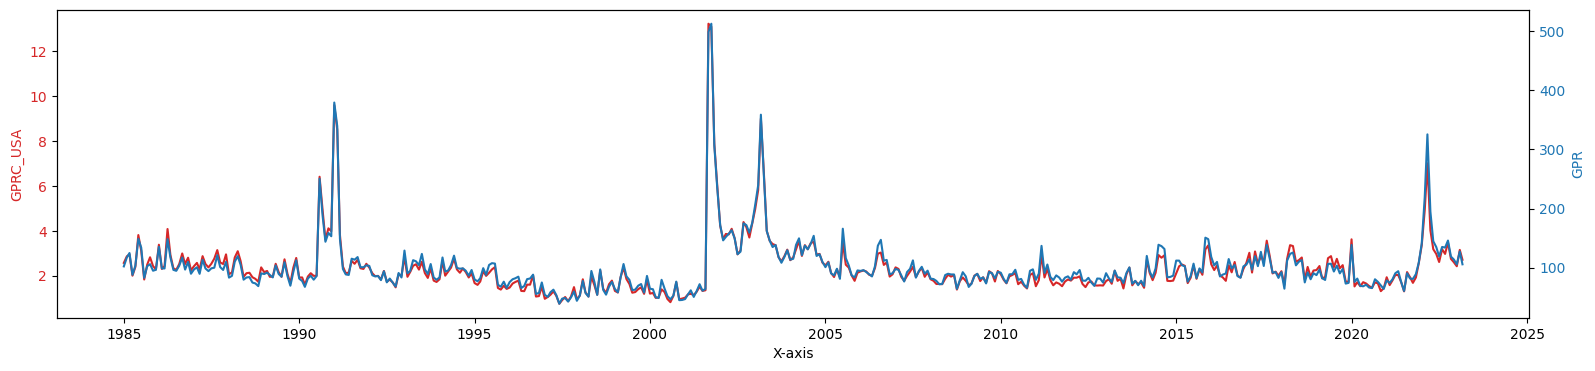

In [43]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(19, 4))

color1 = 'tab:red'
ax1.plot(DATA['GPRC_USA'], color=color1)
ax1.set_ylabel('GPRC_USA', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis (right)
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis (right)
color2 = 'tab:blue'
ax2.plot(DATA['GPR'], color=color2)
ax2.set_ylabel('GPR', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Set x-axis label
ax1.set_xlabel('X-axis')

# Show the plot
plt.show()

#####Second Round Import

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#####Tests & Country Selection

In [48]:
#testing for causality with granger's causality test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(DATA, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(DATA[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

Pvalues = grangers_causation_matrix(DATA, variables = DATA.columns)
#If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

In [51]:
Countries = Pvalues[Pvalues['Price_x'] < 0.05].index
Countries

Index(['GPRC_BRA_y', 'GPRC_CHN_y', 'GPRC_HKG_y', 'GPRC_PHL_y', 'GPRC_POL_y',
       'GPRC_RUS_y', 'GPRC_THA_y', 'GPRC_TUN_y', 'GPRC_TWN_y', 'GPRC_UKR_y',
       'GPRC_VEN_y'],
      dtype='object')

In [ ]:
Pvalues

In [65]:
DATA = DATA[['Price','GPRC_BRA','GPRC_USA','GPRC_CHN','GPRC_HKG','GPRC_IND','GPRC_NLD','GPRC_TWN','GPRC_RUS','GPRC_UKR','GPRC_ZAF','GPRC_AUS']]

In [66]:
DATA

,Price,GPRC_BRA,GPRC_USA,GPRC_CHN,GPRC_HKG,GPRC_IND,GPRC_NLD,GPRC_TWN,GPRC_RUS,GPRC_UKR,GPRC_ZAF,GPRC_AUS
Date,,,,,,,,,,,,
1985-01-01,979.210526,0.05,2.57,0.28,0.01,0.17,0.11,0.03,1.41,0.01,0.16,0.06
1985-02-01,974.075000,0.02,2.86,0.18,0.05,0.11,0.09,0.01,1.37,0.01,0.08,0.35
1985-03-01,994.414286,0.02,2.95,0.11,0.02,0.25,0.07,0.00,1.51,0.03,0.15,0.12
1985-04-01,1045.275000,0.03,2.00,0.20,0.02,0.16,0.05,0.02,0.91,0.03,0.14,0.07
1985-05-01,1004.309524,0.07,2.39,0.13,0.01,0.25,0.04,0.01,1.16,0.01,0.16,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,1298.954545,0.13,2.75,1.15,0.19,0.30,0.11,0.40,2.49,2.48,0.08,0.12
2022-12-01,1453.411765,0.06,2.60,0.89,0.07,0.25,0.09,0.30,2.33,2.26,0.04,0.20
2023-01-01,908.809524,0.12,2.42,0.70,0.03,0.20,0.21,0.17,2.03,1.99,0.04,0.13


In [67]:
#cointegration test to find statistical relation amongst variables.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(DATA, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(DATA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(DATA.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DATA)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  463.24    > 311.1288  =>   True
GPRC_BRA ::  369.28    > 263.2603  =>   True
GPRC_USA ::  283.85    > 219.4051  =>   True
GPRC_CHN ::  225.39    > 179.5199  =>   True
GPRC_HKG ::  174.35    > 143.6691  =>   True
GPRC_IND ::  126.69    > 111.7797  =>   True
GPRC_NLD ::  88.44     > 83.9383   =>   True
GPRC_TWN ::  58.3      > 60.0627   =>   False
GPRC_RUS ::  28.83     > 40.1749   =>   False
GPRC_UKR ::  13.61     > 24.2761   =>   False
GPRC_ZAF ::  4.12      > 12.3212   =>   False
GPRC_AUS ::  0.03      > 4.1296    =>   False


If there is cointegration:
1.    Implies that the series in question are related and therefore can be combined in a linear fashion.
2.  That is, even if there are shocks in the short run, which may affect movement in the individual series, they would converge with time (in the long run).
3.    Estimate both long-run and short-run models.
4. The estimation will require the use of vector autoregressive (VAR) model and vector error correction model (VECM) analysis.

If there is no cointegration:
1.    Estimate only the short-run model, which is VAR and not VECM.
source : http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html

In [68]:
nobs = 20
DATA_train, DATA_test = DATA[0:-nobs], DATA[-nobs:]

# Check size
print(DATA_train.shape)  # (439, 12)
print(DATA_test.shape)  # (20, 12)

(439, 12)
(20, 12)


In [69]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [70]:
# ADF Test on each column
for name, column in DATA_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

<ipython-input-70-bfc95715b77e>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4924
 No. Lags Chosen       = 9
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0082. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2805
 No. Lags Chosen       = 2
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [71]:
#series needs to be stationary hence differencing it.
#1st difference
DATA_train = DATA_train.diff().dropna()


In [72]:
# ADF Test on each column
for name, column in DATA_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

<ipython-input-72-bfc95715b77e>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9044
 No. Lags Chosen       = 16
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.4562
 No. Lags Chosen       = 7
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

Now after 1st order of differencing as per the ADF test where p value < 0.05 it can be said the series is stationary

#####VAR

In [74]:
model = VAR(DATA_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -42.385032094736566
BIC :  -40.92857997017155
FPE :  3.9129649758417594e-19
HQIC:  -41.81029974466811 

Lag Order = 2
AIC :  -42.878838275782876
BIC :  -40.073121135863815
FPE :  2.3911863992052407e-19
HQIC:  -41.771567406270506 

Lag Order = 3
AIC :  -43.01060144279396
BIC :  -38.85093790761379
FPE :  2.1031995434541213e-19
HQIC:  -41.368844694886945 

Lag Order = 4
AIC :  -43.02864411443384
BIC :  -37.51032571339458
FPE :  2.079391006435453e-19
HQIC:  -40.850442688576265 

Lag Order = 5
AIC :  -43.03201029693773
BIC :  -36.15030125098433
FPE :  2.0953991688210366e-19
HQIC:  -40.31539386091457 

Lag Order = 6
AIC :  -42.949493725348006
BIC :  -34.699630726964116
FPE :  2.3138203171403947e-19
HQIC:  -39.69248032129227 

Lag Order = 7
AIC :  -42.769998629167766
BIC :  -33.14719062010553
FPE :  2.834754588451976e-19
HQIC:  -38.970594579617185 

Lag Order = 8
AIC :  -42.53173252939663
BIC :  -31.531160476112035
FPE :  3.7140668114448117e-19
HQIC:  -38.18793234238815 


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [75]:
x = model.select_order(maxlags=12)
x.summary()


,AIC,BIC,FPE,HQIC
0,-41.29,-41.18*,1.166e-18,-41.25
1,-42.46,-40.97,3.642e-19,-41.87*
2,-42.97,-40.11,2.193e-19,-41.84
3,-43.09,-38.87,1.934e-19,-41.43
4,-43.10*,-37.51,1.931e-19*,-40.89
5,-43.09,-36.12,1.985e-19,-40.34
6,-43.02,-34.68,2.170e-19,-39.72
7,-42.88,-33.17,2.547e-19,-39.04
8,-42.59,-31.51,3.503e-19,-38.22
9,-42.39,-29.95,4.455e-19,-37.48


In [76]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, May, 2023
Time:                     05:47:11
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -40.0731
Nobs:                     436.000    HQIC:                  -41.7716
Log likelihood:           2223.70    FPE:                2.39119e-19
AIC:                     -42.8788    Det(Omega_mle):     1.22473e-19
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               3.071588        18.624773            0.165           0.869
L1.Price            0.446252         0.048939            9.119           0.000
L1.GPRC_BRA     -2431.871416       652.741097           -3.726      

In [77]:
#to check if any serial pattern is still left in the residuals durbin watson statistical test can be performed.
#The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
#then there is no significant serial correlation.
#The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(DATA_train.columns, out):
    print(col, ':', round(val, 2))

Price : 2.03
GPRC_BRA : 2.09
GPRC_USA : 2.06
GPRC_CHN : 2.05
GPRC_HKG : 1.98
GPRC_IND : 2.09
GPRC_NLD : 2.14
GPRC_TWN : 2.05
GPRC_RUS : 2.11
GPRC_UKR : 2.1
GPRC_ZAF : 2.04
GPRC_AUS : 2.09


As the values are closer to 2 no significant correlation.

#####Forecast

In [78]:
#forecasting
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = DATA_train.values[-lag_order:]
forecast_input

2


array([[-3.32631579e+01,  0.00000000e+00, -3.20000000e-01,
         1.10000000e-01,  6.00000000e-02, -1.30000000e-01,
         3.00000000e-02,  3.00000000e-02,  0.00000000e+00,
        -4.00000000e-02,  1.00000000e-02,  1.00000000e-02],
       [ 2.55954545e+02, -3.00000000e-02, -4.10000000e-01,
        -2.20000000e-01, -4.00000000e-02,  0.00000000e+00,
        -2.00000000e-02, -3.00000000e-02, -3.30000000e-01,
        -1.40000000e-01, -1.00000000e-02, -1.10000000e-01]])

In [79]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=DATA.index[-nobs:], columns=DATA.columns + '_2d')
df_forecast

,Price_2d,GPRC_BRA_2d,GPRC_USA_2d,GPRC_CHN_2d,GPRC_HKG_2d,GPRC_IND_2d,GPRC_NLD_2d,GPRC_TWN_2d,GPRC_RUS_2d,GPRC_UKR_2d,GPRC_ZAF_2d,GPRC_AUS_2d
Date,,,,,,,,,,,,
2021-08-01,241.655431,2.195720e-02,0.455891,0.150144,0.013882,0.058082,0.027612,0.016854,0.189583,0.103050,-0.007892,0.072617
2021-09-01,-2.124523,-6.796398e-03,-0.114575,-0.042112,0.004272,-0.024391,-0.006276,0.004034,0.005926,-0.001722,0.005110,-0.019915
2021-10-01,5.822475,-3.852419e-03,-0.094953,-0.009302,-0.008402,-0.015027,-0.010033,-0.008296,-0.051008,-0.025192,-0.003954,-0.003433
2021-11-01,7.604696,4.749852e-03,0.028035,0.026923,0.004556,0.012838,0.007319,0.003659,0.006617,0.004713,0.000881,0.003663
2021-12-01,-0.167371,-2.046351e-03,0.007584,-0.017562,-0.000384,-0.000194,-0.000075,0.000180,0.001938,0.004686,0.001080,-0.002407
2022-01-01,8.468789,-6.237451e-05,0.010371,0.006052,-0.000530,-0.001438,-0.001090,0.000251,0.003521,0.001679,-0.001704,0.002669
2022-02-01,3.910408,7.294703e-04,-0.017587,0.004512,0.001224,-0.000767,-0.000032,0.000491,-0.005234,-0.001842,0.000291,-0.002027
2022-03-01,5.133933,-5.446766e-04,-0.006745,-0.002547,-0.000543,0.000523,0.000054,-0.000283,-0.004445,0.000101,-0.000080,-0.000086
2022-04-01,6.074762,1.579336e-04,0.006970,0.002145,0.000293,0.000892,0.000505,0.000627,0.001400,0.001567,-0.000302,0.000694


In [80]:
#inverting the values from differencing
def invert_transformation(DATA_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = DATA_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_2d'] = (DATA_train[col].iloc[-1]-DATA_train[col].iloc[-2]) + DATA_train[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = DATA_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc

In [82]:
df_results = invert_transformation(DATA_train, df_forecast)        
df_results

,Price_2d,GPRC_BRA_2d,GPRC_USA_2d,GPRC_CHN_2d,GPRC_HKG_2d,GPRC_IND_2d,GPRC_NLD_2d,GPRC_TWN_2d,GPRC_RUS_2d,GPRC_UKR_2d,...,GPRC_USA_forecast,GPRC_CHN_forecast,GPRC_HKG_forecast,GPRC_IND_forecast,GPRC_NLD_forecast,GPRC_TWN_forecast,GPRC_RUS_forecast,GPRC_UKR_forecast,GPRC_ZAF_forecast,GPRC_AUS_forecast
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-01,241.655431,2.195720e-02,0.455891,0.150144,0.013882,0.058082,0.027612,0.016854,0.189583,0.103050,...,0.045891,-0.069856,-0.026118,0.058082,0.007612,-0.013146,-0.140417,-0.036950,-0.017892,-0.037383
2021-09-01,-2.124523,-6.796398e-03,-0.114575,-0.042112,0.004272,-0.024391,-0.006276,0.004034,0.005926,-0.001722,...,-0.068684,-0.111968,-0.021846,0.033691,0.001337,-0.009113,-0.134491,-0.038672,-0.012783,-0.057298
2021-10-01,5.822475,-3.852419e-03,-0.094953,-0.009302,-0.008402,-0.015027,-0.010033,-0.008296,-0.051008,-0.025192,...,-0.163637,-0.121270,-0.030249,0.018664,-0.008697,-0.017409,-0.185499,-0.063864,-0.016737,-0.060731
2021-11-01,7.604696,4.749852e-03,0.028035,0.026923,0.004556,0.012838,0.007319,0.003659,0.006617,0.004713,...,-0.135602,-0.094347,-0.025693,0.031502,-0.001378,-0.013750,-0.178882,-0.059151,-0.015856,-0.057068
2021-12-01,-0.167371,-2.046351e-03,0.007584,-0.017562,-0.000384,-0.000194,-0.000075,0.000180,0.001938,0.004686,...,-0.128018,-0.111909,-0.026078,0.031308,-0.001452,-0.013570,-0.176944,-0.054464,-0.014776,-0.059475
2022-01-01,8.468789,-6.237451e-05,0.010371,0.006052,-0.000530,-0.001438,-0.001090,0.000251,0.003521,0.001679,...,-0.117647,-0.105857,-0.026608,0.029870,-0.002543,-0.013319,-0.173424,-0.052785,-0.016480,-0.056806
2022-02-01,3.910408,7.294703e-04,-0.017587,0.004512,0.001224,-0.000767,-0.000032,0.000491,-0.005234,-0.001842,...,-0.135233,-0.101345,-0.025384,0.029103,-0.002574,-0.012828,-0.178658,-0.054627,-0.016189,-0.058833
2022-03-01,5.133933,-5.446766e-04,-0.006745,-0.002547,-0.000543,0.000523,0.000054,-0.000283,-0.004445,0.000101,...,-0.141978,-0.103891,-0.025927,0.029627,-0.002520,-0.013112,-0.183102,-0.054526,-0.016269,-0.058919
2022-04-01,6.074762,1.579336e-04,0.006970,0.002145,0.000293,0.000892,0.000505,0.000627,0.001400,0.001567,...,-0.135009,-0.101746,-0.025634,0.030519,-0.002015,-0.012485,-0.181703,-0.052959,-0.016572,-0.058225


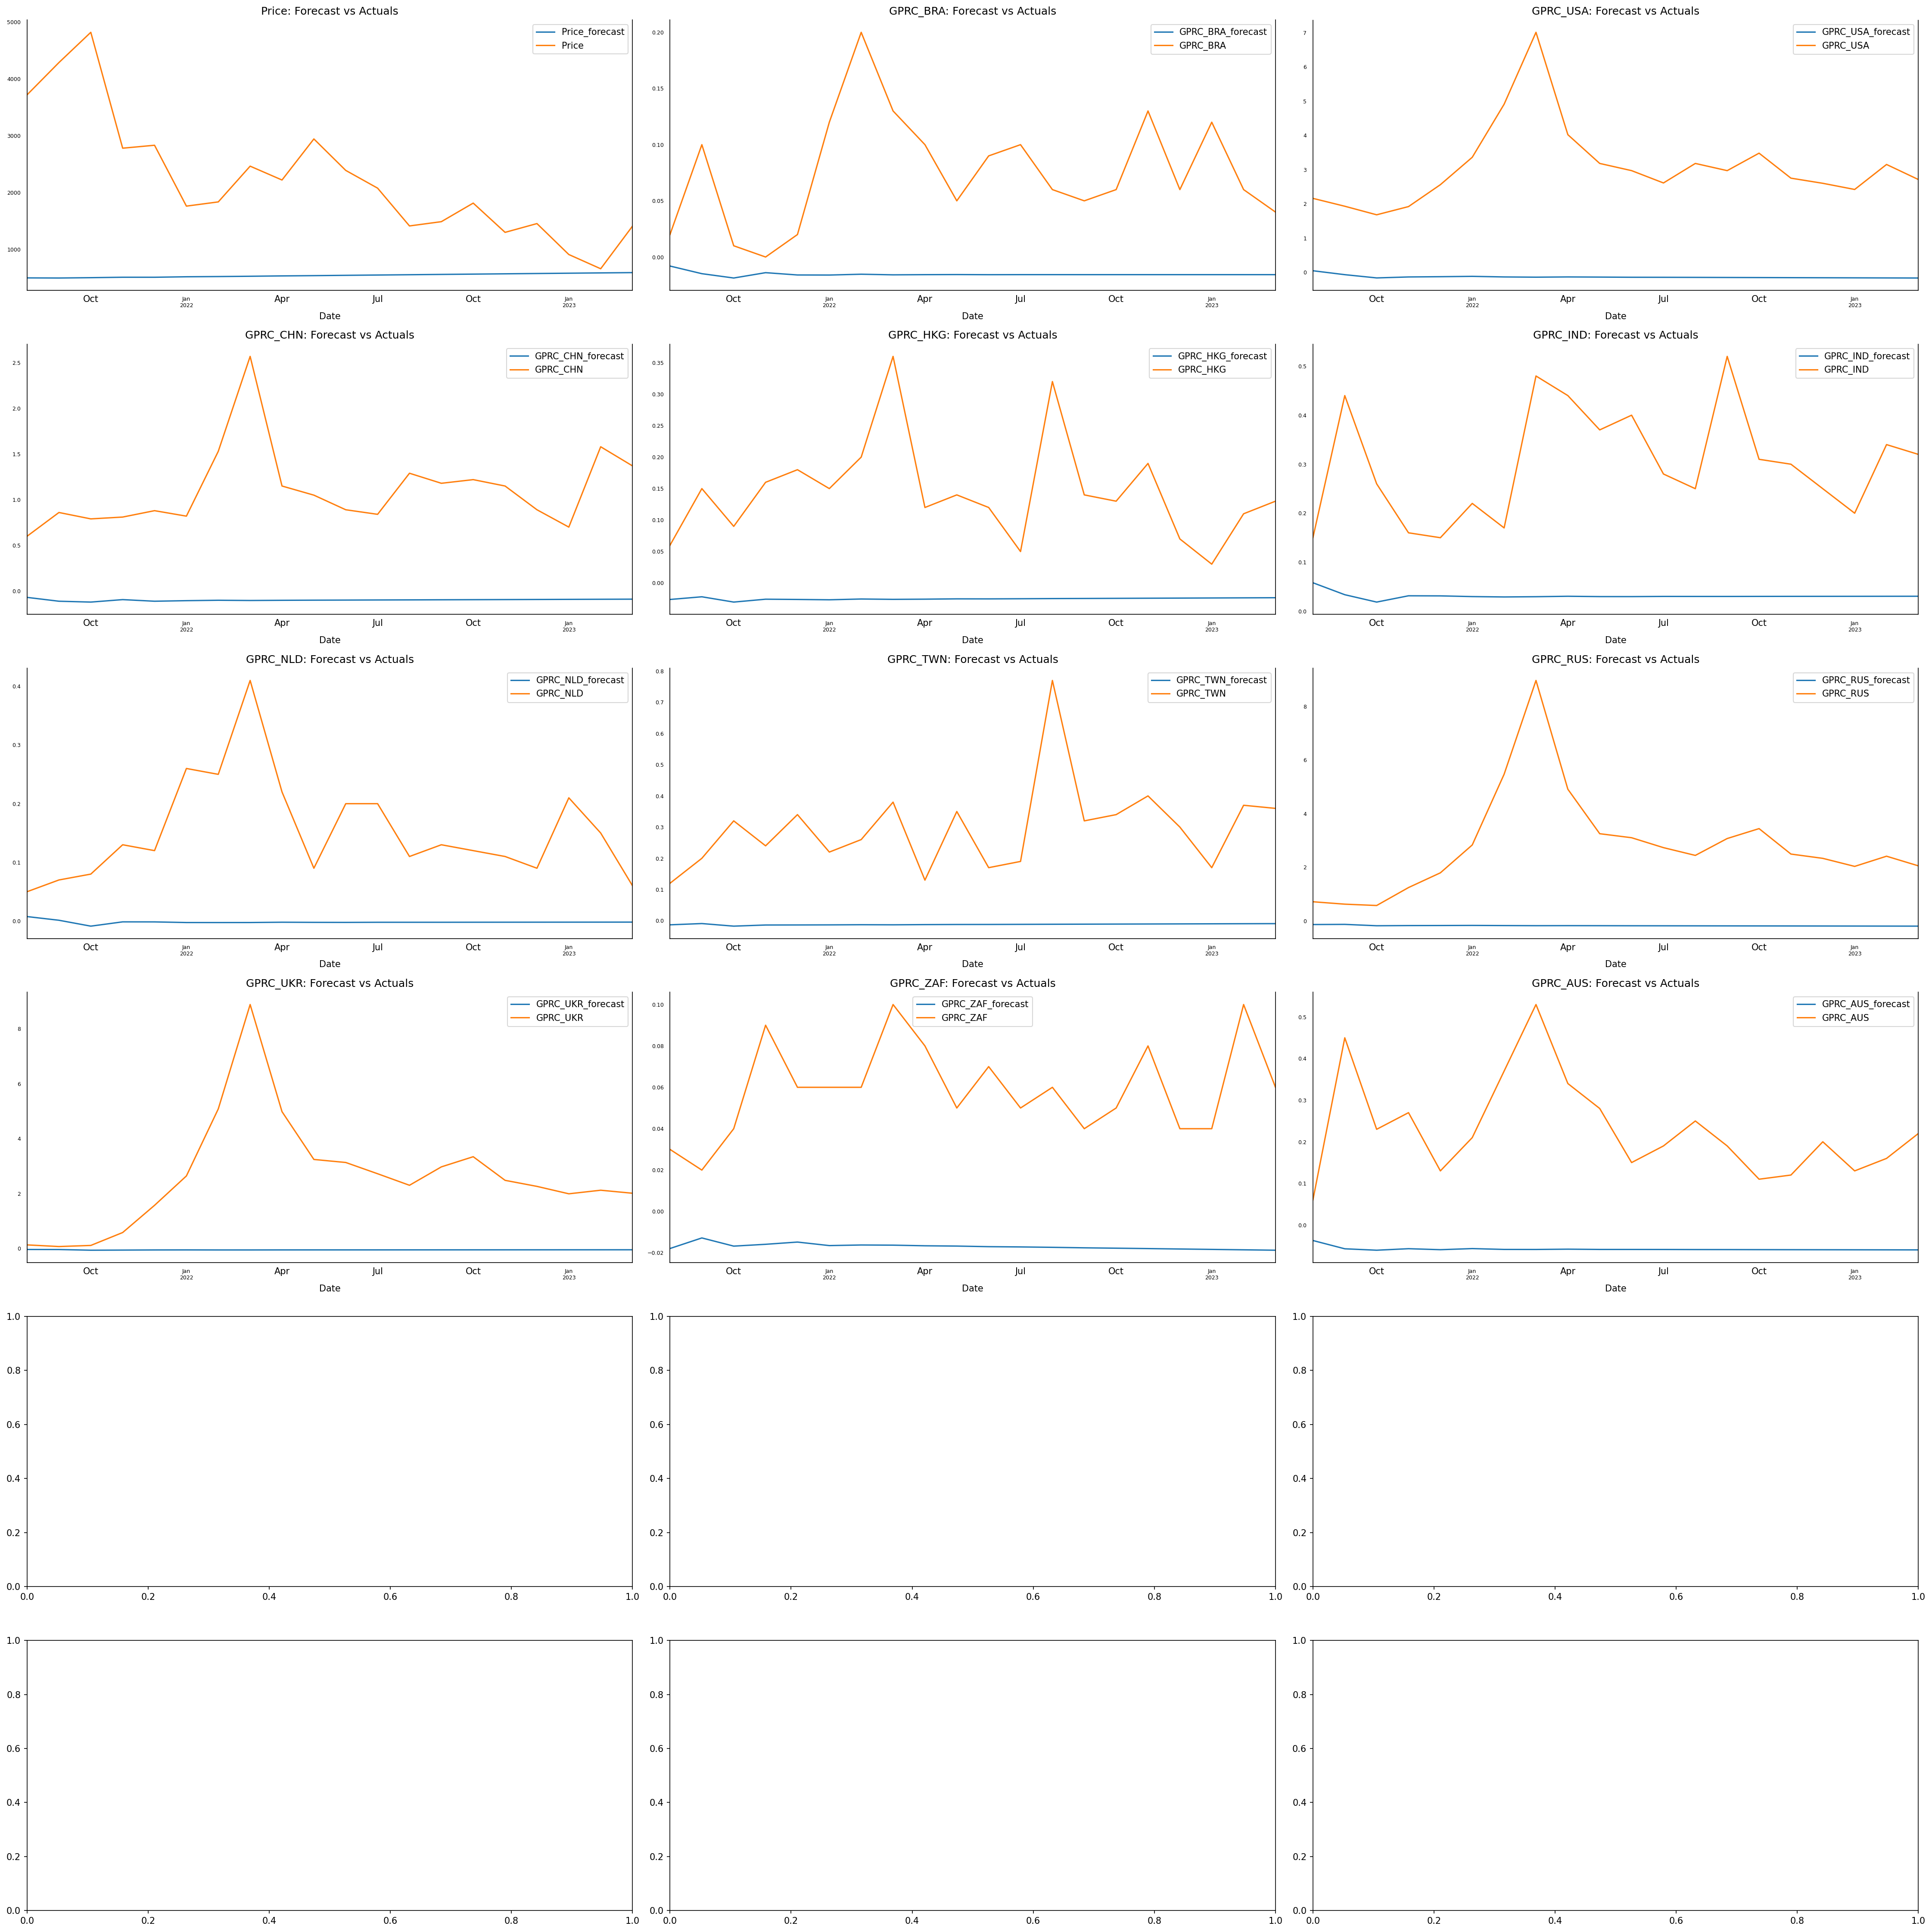

In [84]:
fig, axes = plt.subplots(nrows=int(len(DATA.columns)/2), ncols=3, dpi=150, figsize=(30,30))
for i, (col,ax) in enumerate(zip(DATA.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DATA_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();